<a href="https://colab.research.google.com/github/yangtianchangxiao/Dissertation-project-in-Bristol/blob/main/CSO_records_trails_in_an_excel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import pandas as pd
import openpyxl as op
from google.colab import files

In [147]:
#upload = files.upload() 
bg = op.load_workbook(r"/content/cso_robot_trail.xlsx") 

In [148]:
#upload = files.upload()
df  = pd.read_excel('/content/Environment.xlsx')
environment_data = df.iloc[0:,1:]

Initiate SMP.CDC.SRD and SPC

In [149]:
# Seeking mode set
SMP = 8 # 10 copies of cat 
CDC = 0.5 # Half dimension will change.
SRD = 1 # Change rate is 10%
SPC = True 
SPC_ratio = 0.1
seeking_group = 5
coordinate_dimension = 2
best_cat_x = 0
best_cat_y = 0

# Environment Initial
def f(x1,x2): 
   return 3*x1**2-2.1*x1**4+(x1**6)/3+x1*x2-4*x2**2+4*x2**4
#Generate searching area
area_width = 15
area_height = 13
area = [0,area_width,0,area_height]
x=np.linspace(area[0],area[1],200)
y=np.linspace(area[2],area[3],200)
X,Y= np.meshgrid(x,y)
Fitness = f(X,Y)

#ax3 = plt.axes(projection='3d')
#ax3.plot_surface(X,Y,Fitness,cmap='rainbow')
#area_size = (area[1]-area[0])*(area[3]-area[2])
#print(type(Fitness))
#print("max(Fitness)", np.max(Fitness))

#print(f(1,1.133867299686855))
#tracing


tracing_group_size = 3
iteration = 100
accuracy = 0.0001

max_tracing_velocity = min(area[1]-area[0],area[3]-area[2])/40
tracing_velocity = np.zeros((coordinate_dimension,tracing_group_size))
tracing_position = np.zeros((coordinate_dimension,tracing_group_size))
c = 1.5
group_size = seeking_group + tracing_group_size
group = np.zeros((2,seeking_group + tracing_group_size))
cats = np.zeros((2,seeking_group))

In [150]:
xita = 0.5
distance = 0
detect_targets = False
ap = 10
av = 0
m = 2
n = 1.2
v = 0 # velocity
v_last = 0
v_last = 0
a = 0.1 # acceleration
v_target = 0
detection_range = 2
fetch_range = 0.5

In [151]:
block_data = []
block_data = []
area_width = 15
area_height = 13
block_num = 5
max_block_width = 1.7
max_block_height = 1.7
block_parameters=np.zeros((6,block_num))
influence_gain = 1.2 # Set danger area around a block. If a block is 1.3*1.4 size with a center (2.3,2.4),
            # then the danger area is (1.2*1.3)*(1.2*1.4) size with the same center (2.3,2.4).
influence_range = 0.5 # distance to the block
block_influence_range_parameters=np.zeros((6,block_num))
targets_num = 1
targets_location = np.zeros((2,targets_num))
fig = plt.figure()
def generate_block():
  global block_parameters, block_influence_range_parameters,block_num
  if block_num == 0:
    block_num = 1
    block_parameters[:,:] = 0
    block_influence_range_parameters[:,:] = 0
    return block_parameters
  for i in range(block_num):
    #initiate x and y coordinates of block_cneter 
    for j in range(6):
      block_parameters[j][i] = environment_data.iloc[epoch][i*6+j]
    for j in range(2):
      block_influence_range_parameters[j][i] = block_parameters[j][i]
    for j in range(2,6):
      block_influence_range_parameters[j][i] = block_parameters[j][i] + influence_range/2
  #print(block_parameters)
  return(block_parameters)
def plot_block(parameters):
  global fig
  for i in range(block_num):
    x = [parameters[0][i]-parameters[2][i], parameters[0][i]+parameters[3][i]] #coordiantes of left and right boundary of blocks
    y = [parameters[1][i]-parameters[4][i], parameters[1][i]+parameters[5][i]] #coordiantes of down and up boundary of blocks
    block_data.append(x[0],x[1],y[0],y[1])
    coordinates = [(x[0],y[0]),#left bottom
    (x[0],y[1]),#left top
    (x[1],y[1]),#right top 
    (x[1],y[0]),#right bottom
    (x[0],y[0])# ignored
    ]
    codes = [Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,]
    path = Path(coordinates, codes)
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.add_patch(patch)

def plot_danger_area(parameters):
  global fig
  for i in range(block_num):
    x = [parameters[0][i]-parameters[2][i], parameters[0][i]+parameters[3][i]] #coordiantes of left and right boundary of blocks
    y = [parameters[1][i]-parameters[4][i], parameters[1][i]+parameters[5][i]] #coordiantes of down and up boundary of blocks
    coordinates = [(x[0],y[0]),#left bottom
    (x[0],y[1]),#left top
    (x[1],y[1]),#right top 
    (x[1],y[0]),#right bottom
    (x[0],y[0])# ignored
    ]
    codes = [Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,]
    path = Path(coordinates, codes)
    patch = patches.PathPatch(path, color = None,facecolor = 'None', linestyle ='-', lw=2)
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.add_patch(patch)
def initiate_targets():
  global targets_num, targets_location, fig
  regenate_time = 1
  for i in range(targets_num):
    targets_location[0][i] = environment_data.iloc[epoch][6*block_num+2*i+0]
    targets_location[1][i] = environment_data.iloc[epoch][6*block_num+2*i+1]
    #plt.plot(targets_location[0][i],targets_location[1][i],'>')

<Figure size 432x288 with 0 Axes>

In [152]:
print(environment_data.iloc[6][6*5+0])

6.50818


In [153]:
def distance_to_block(p_x,p_y):
  distance_list = []
  for i in range(block_num):
    x = [block_parameters[0][i]-block_parameters[2][i], block_parameters[0][i]+block_parameters[3][i]] #coordiantes of left and right boundary of blocks
    y = [block_parameters[1][i]-block_parameters[4][i], block_parameters[1][i]+block_parameters[5][i]] #coordiantes of down and up boundary of blocks
    danger_x = [block_influence_range_parameters[1][i]-block_influence_range_parameters[4][i], block_influence_range_parameters[1][i]+block_influence_range_parameters[5][i]]
    danger_y = [block_influence_range_parameters[1][i]-block_influence_range_parameters[4][i], block_influence_range_parameters[1][i]+block_influence_range_parameters[5][i]]
    if x[0]<p_x<x[1]:
      distance_list.append(min(abs(p_y-y[0]),abs(p_y-y[1])))
    elif y[0]<p_y<y[1]:
      distance_list.append(min(abs(p_x-x[0]),abs(p_x-x[1])))
    else:
      distance_list.append(min(p_p_distance(p_x,p_y,x[0],y[0]),p_p_distance(p_x,p_y,x[0],y[1]),p_p_distance(p_x,p_y,x[1],y[0]),p_p_distance(p_x,p_y,x[1],y[1])))
  return min(distance_list)
def p_p_distance(p_x,p_y,x,y):
  return np.sqrt((p_x-x)**2+(p_y-y)**2)


def potential_field(p_x,p_y,last_p_x,last_p_y):
  global v_last, detect_targets
  # global targets_num robots_num

  detect_obstacles = False
  distance_to_tragets = []
  ## 策略一 找到 target 后，不改变 robot 的 target，即使中间遇到更近的

  ## 疑惑 cat copy 在实际中代表什么呢
  for i in range (targets_num):
    a = p_p_distance(last_p_x,last_p_y,targets_location[0][i],targets_location[1][i])
    if a < detection_range:
      detect_targets = True
      #print("Find the target !!!!!!")
      break
  v = p_p_distance(last_p_x,last_p_y,targets_location[0][i],targets_location[1][i])
  a = v - v_last
  v_last = v
  #if distance_to_block(p_x,p_y)-v*v/2/a < influence_range:
  if distance_to_block(p_x,p_y) < influence_range:
    #U_repulsive = xita * (1/(distance_to_block(p_x,p_y)-v*v/2/a)-1/influence_range)
    U_repulsive = xita * (1/(distance_to_block(p_x,p_y))-1/influence_range)
    #print('U_repulsive',U_repulsive)
  else:
    U_repulsive = 0
    #print('U_repulsive',U_repulsive)
    detect_obstacles = True
  if detect_targets == False: #Searching state
    # 假设知道更新后的 cat 与 blocks 的相对位置
    U_attractive = -1 * ap * p_p_distance(p_x,p_y,last_p_x,last_p_y) ** m
    #print('U_attractive',U_attractive)
  else: #Hunting state
    U_attractive = ap * p_p_distance(p_x,p_y,targets_location[0][i],targets_location[1][i]) ** m + av * abs(v_target - v)
    #print('U_attractive',U_attractive)
  f_attractive =   U_attractive + U_repulsive 
  
  return f_attractive


In [154]:
import random
a = random.sample(range(0,7),3)
print(a)
a.sort()
print(a)

[1, 0, 3]
[0, 1, 3]


In [155]:
# initate cats
import random
total_index = list(range(0,group_size))
seeking_index = random.sample(range(0,group_size),seeking_group)
seeking_index.sort()
def initiate_cats(parameters):
  global block_num,seeking_index,total_index,tracing_index
  
  group=np.zeros((coordinate_dimension,group_size))
  total_index = list(range(0,group_size))
  seeking_index = random.sample(range(0,group_size),seeking_group)
  seeking_index.sort()
  #print(np.shape(group))
  for i in range(group_size):
    x_cat = environment_data.iloc[epoch][6*block_num+2*targets_num+i*2+0]
    y_cat = environment_data.iloc[epoch][6*block_num+2*targets_num+i*2+1]
    group[0][i]=x_cat
    group[1][i]=y_cat
  for seeking_num in range(seeking_group):
    #print(seeking_index[seeking_num])
    total_index.remove(seeking_index[seeking_num])
    total_index.sort()
    tracing_index = total_index
  for i in range(seeking_group):
    cats[0][i] = group[0][seeking_index[i]]
    cats[1][i] = group[1][seeking_index[i]]
  for i in range(tracing_group_size):
    tracing_position[0][i] = group[0][tracing_index[i]]
    tracing_position[1][i] = group[1][tracing_index[i]]
  #print("shape of group",np.shape(group))
  return group


In [156]:
# seeking function

def generate_candidate (P,parameters):
  array_shape = np.shape(P)
  array_column = array_shape[1]
  array_row = array_shape[0]
  candidate_group = np.zeros((seeking_group,SMP,1,array_row))
  area_range = [area[1]-area[0],area[3]-area[2]]
  # initial candicates
  for column in range(seeking_group):
    if(np.random.random()>SPC_ratio):
      candidates_num = SMP - 1
      for i in range(candidates_num):
        CDC_array_init = np.random.randn(2)/50
        # if note next two lines below, then the CDC is 0 and both dimensions change in seeking mode
        #a = np.ndarray.tolist(CDC_array_init)
        #CDC_array_init[a.index(np.min(a))]=np.min(a)
        CDC_array = round(np.random.random(),2)* np.random.choice((-1, 1))* CDC_array_init.reshape(1,array_row)
        #print(P[:,column]+CDC_array*np.max(a))
        candidate_group[column][i] = P[:,column]+CDC_array * area_range #*np.max(a)
        # constraint on positions
       
        block_count = 0
        #print(block_num,'is block_num')
        while block_count < block_num:

          if candidate_group[column][i][0][0] > area[1]:
            candidate_group[column][i][0][0] = area[1]
          if candidate_group[column][i][0][0] < area[0]:
            candidate_group[column][i][0][0] = area[0]
          if candidate_group[column][i][0][1] > area[3]:
            candidate_group[column][i][0][1] = area[3]
          if candidate_group[column][i][0][1] < area[2]:
            candidate_group[column][i][0][1] = area[2]

          x_block = [parameters[0][block_count]-parameters[2][block_count], parameters[0][block_count]+parameters[3][block_count]] #coordiantes of left and right boundary of blocks
          y_block = [parameters[1][block_count]-parameters[4][block_count], parameters[1][block_count]+parameters[5][block_count]] #coordiantes of down and up boundary of blocks
          if x_block[0] < candidate_group[column][i][0][0] <x_block[1] and y_block[0] < candidate_group[column][i][0][1] <y_block[1]:
            CDC_array_init = np.random.randn(2)/20
            CDC_array = round(np.random.random(),2)* np.random.choice((-1, 1))* CDC_array_init.reshape(1,array_row)
            candidate_group[column][i] = P[:,column]+CDC_array * area_range #*np.max(a)
            block_count = 0
          else:
            block_count = block_count + 1
          #print('block_count is ',block_count)
      candidate_group[column][SMP-1] = P[:,column]
    else:
      candidates_num = SMP
      for i in range(candidates_num):
        CDC_array_init = np.random.randn(2)/5
        #a = np.ndarray.tolist(CDC_array_init)
        #CDC_array_init[a.index(np.min(a))]=0
        #CDC_array = round(np.random.random(),2)*CDC_array_init.reshape(1,array_row)
        CDC_array = round(np.random.random(),2)* np.random.choice((-1, 1))* CDC_array_init.reshape(1,array_row)
        #print(P[:,column]+CDC_array*np.max(a))
        candidate_group[column][i] = P[:,column]+CDC_array * area_range #*np.max(a)
        block_count = 0
        #print(block_num,'is block_num')
        while block_count < block_num:

          # constraint on positions
          if candidate_group[column][i][0][0] > area[1]:
            candidate_group[column][i][0][0] = area[1]
          if candidate_group[column][i][0][0] < area[0]:
            candidate_group[column][i][0][0] = area[0]
          if candidate_group[column][i][0][1] > area[3]:
            candidate_group[column][i][0][1] = area[3]
          if candidate_group[column][i][0][1] < area[2]:
            candidate_group[column][i][0][1] = area[2]

          x_block = [parameters[0][block_count]-parameters[2][block_count], parameters[0][block_count]+parameters[3][block_count]] #coordiantes of left and right boundary of blocks
          y_block = [parameters[1][block_count]-parameters[4][block_count], parameters[1][block_count]+parameters[5][block_count]] #coordiantes of down and up boundary of blocks
          if x_block[0] < candidate_group[column][i][0][0] <x_block[1] and y_block[0] < candidate_group[column][i][0][1] <y_block[1]:
            CDC_array_init = np.random.randn(2)/5
            CDC_array = round(np.random.random(),2)* np.random.choice((-1, 1))* CDC_array_init.reshape(1,array_row)
            candidate_group[column][i] = P[:,column]+CDC_array * area_range #*np.max(a) 
            block_count = 0
          else:
            block_count = block_count + 1 
          #print('block_count is ',block_count)       
  #print("candidate_group shape",np.shape(candidate_group))
  return candidate_group


In [157]:
max_value = -100
last_max_value = -100
min_value = 100000
def evaluate(group,original_group):
  #print("Start evaluating")
  global min_value
  global best_cat_x, best_cat_y, individual_best_x, individual_best_y
  index_list=[]
  value_list=[]
  max_value_list = []
  min_value_list = []
  for cat in range(seeking_group):
    #max_value = -100
    candidate_index = 0
    #min_value = 100
    for copy in range(SMP):
      min_value = 10000
      candidate_value=potential_field(group[cat][copy][0][0],group[cat][copy][0][1],original_group[0][cat],original_group[1][cat])
      value_list.append(candidate_value)
      #print(candidate_value)
      if(candidate_value < min_value):
        min_value = candidate_value
        individual_best_x = best_cat_x = group[cat][copy][0][0]
        individual_best_y = best_cat_y = group[cat][copy][0][1]


    
    max_value_list = max(value_list)
    min_value_list = min(value_list)
    #print('value_list',value_list)
    #print('min_value_list',)
    for copy in range(SMP):
      value_list[copy] = abs(value_list[copy] - max_value_list) / (max_value_list - min_value_list)
    for copy in range(SMP):
      if copy > 0:
        value_list[copy] = value_list[copy]+value_list[copy-1]
    #print('value_list',value_list)
    selected_value = np.random.uniform(value_list[copy],0)
    #print('selected_value',selected_value)
    value_list.append(selected_value)
    value_list.sort()
    candidate_index = value_list.index(selected_value)
    #print(candidate_index)
    index_list.append(candidate_index)
    #print("max_value is",max_value)
    value_list = []
  #print("index_list",index_list)
  #print("best_cat_x",best_cat_x)
  #print("best_cat_y",best_cat_y)
  #print("max_value in evaluate", max_value)
  #print('best cat is in',best_cat_x,best_cat_y)
  #print(min_value, 'is min_value')
  return index_list



In [158]:
def next_group(original_group,candidate_group,index):
  array_column = seeking_group
  #print('array_column',array_column)
  array_row = 2
  new_group=np.zeros((array_row,array_column))
  #print(np.shape(new_group))
  #print(np.shape(candidate_group))
  #print('index',index)
  #print('index[1:15]',index[1:15])
  for i in range(array_column):
    for j in range(array_row):
      #print(candidate_group.shape)
      #print('i',i)
      #print(candidate_group[i][index[i]][0][j])
      new_group[j][i] = candidate_group[i][index[i]][0][j]
  return new_group


In [159]:
#seeking mode initiation

def tracing_velocity_initiate(group):
  for i in range(group):
    tracing_velocity[0][i] = np.random.uniform(max_tracing_velocity,0)
    tracing_velocity[1][i] = np.random.uniform(max_tracing_velocity,0)

In [160]:
def trace_update(group, original_group, velocity,position,parameters):
  global tracing_velocity, tracing_position, seeking_group
  eking = 0
  get_stuck_count = 0
  get_stuck_count_threshold = 5
  best_cat_array = np.empty((2,tracing_group_size))
  group_value_list = []
  for cat in range (seeking_group):
    candidate_value=potential_field(group[0][cat],group[1][cat],original_group[0][cat],original_group[1][cat])
    group_value_list.append(candidate_value)
  min_group_value = min(group_value_list)
  index_of_min_value = group_value_list.index(min_group_value) 
  best_cat_x = group[0][index_of_min_value]
  best_cat_y = group[1][index_of_min_value]
  for i in range(tracing_group_size):
    best_cat_array[0][i] = best_cat_x
    best_cat_array[1][i] = best_cat_y
  block_count = 0
  x_block = [parameters[0][block_count]-parameters[2][block_count], parameters[0][block_count]+parameters[3][block_count]] #coordiantes of left and right boundary of blocks
  y_block = [parameters[1][block_count]-parameters[4][block_count], parameters[1][block_count]+parameters[5][block_count]] #coordiantes of down and up boundary of blocks
  while block_count < block_num:
    tracing_velocity_temporary = velocity + c * np.random.random()*(best_cat_array-position)
    index1 = np.where(tracing_velocity_temporary>max_tracing_velocity)
    index2 = np.where(tracing_velocity_temporary<-max_tracing_velocity)
    tracing_velocity_temporary[index1] = max_tracing_velocity
    tracing_velocity_temporary[index2] = -max_tracing_velocity
    #print("tracing_position",position)
    #print("best_cat_array",best_cat_array)
    tracing_position_temporary = position + tracing_velocity_temporary
      # constraint on positions
    for i in range(tracing_group_size):
      if tracing_position_temporary[0][i] > area[1]:
        tracing_position_temporary[0][i] = area[1]
      elif tracing_position_temporary[0][i] < area[0]:
        tracing_position_temporary[0][i] = area[0]
      if tracing_position_temporary[1][i] > area[3]:
        tracing_position_temporary[1][i] = area[3]
      elif tracing_position_temporary[1][i] < area[2]:
        tracing_position_temporary[1][i] = area[2]
    #index3 = np.where(tracing_position > area[1])
    #index4 = np.where(tracing_position < area[0])
    #tracing_position[index3] = area[1]
    #tracing_position[index4] = area[0]
    #print('block count is ',block_count)
    #print(tracing_position,' is tracing position.')
    for tracing_cat_count in range(tracing_group_size):
      
      #print('tracing_group_size',tracing_group_size)
      if x_block[0]<tracing_position_temporary[0][tracing_cat_count]<x_block[1] and y_block[0]<tracing_position_temporary[1][tracing_cat_count]<y_block[1]:
        #print('x_block is ',x_block)
        #print('y_block is', y_block)
        #print('tracing_position[0][tracing_cat_count]',tracing_position[0][tracing_cat_count])
        #print('tracing_position[1][tracing_cat_count]',tracing_position[1][tracing_cat_count])
        #print(tracing_cat_count, ' is tracing_cat_count and coverd by block',block_count)
        block_count = 0
        get_stuck_count = get_stuck_count + 1
        break
    if get_stuck_count == get_stuck_count_threshold:
      print('get stuck !!!')
      break
    #print('tracing_cat_count',tracing_cat_count)
    if tracing_cat_count == tracing_group_size-1:
      #print('Not in block ',block_count)
      block_count = block_count + 1
    #print(tracing_position)
    #print("tracing_velocity",tracing_velocity)
  tracing_velocity = tracing_velocity_temporary
  tracing_position = tracing_position_temporary


In [161]:
def initiate_all(parameters):
  cats=initiate_cats(parameters)
  #print(cats)
  #print(generate_candidate(cats))

  
  tracing_velocity_initiate(tracing_group_size)
  #print(tracing_velocity)
  #print(tracing_position)
  return cats


In [162]:
#def main():
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

experiment_times = 50
iteration_list = []
total_journey = 0
journey_list = []
sheet = bg["Sheet1"]
print(type(journey_list))
for epoch in range (experiment_times):
  generate_block()
  initiate_targets()
  # plot_block(block_parameters) 
  # plot_danger_area(block_influence_range_parameters) 
  # plt.show()
  last_min_value = 100
  cats = initiate_all(block_parameters)
  stable_num = 0
  find_target = False
  success_count = 0
  
  
  find_target = False
  success_count = 0
  journey_in_epoch = 0
  print('cats shape begin epoch',cats.shape)
  for iterationn_counts in range(iteration):
    
    # plot_block(block_parameters) 
    # plot_danger_area(block_influence_range_parameters)
    # plt.plot(cats[0,:],cats[1,0:],'+')
    # plt.plot(tracing_position[0,:],tracing_position[1,:],'x',)
    # plt.plot(targets_location[0,:],targets_location[1,:],'*',)
    # plt.show()
    # fig = plt.figure()
    #print('targets_location is ',targets_location)
     
   
    last_tracing_position = tracing_position
    #print('cats shape',cats.shape)
    candidates = generate_candidate(cats,block_parameters)
    new_group_index = evaluate(candidates,cats)
    #print('new_group_index',new_group_index)
    new_cats= next_group(cats,candidates,new_group_index)
    #print(new_cats)
    for i in range(seeking_group):
      journey_in_epoch = journey_in_epoch + p_p_distance(new_cats[0][i],new_cats[1][i],cats[0][i],cats[1][i])
    trace_update(new_cats, cats, tracing_velocity,tracing_position,block_parameters)
    # re-select cats and tracing position randomly
    for i in range(seeking_group):
      group[0][seeking_index[i]] = new_cats[0][i]  
      group[1][seeking_index[i]] = new_cats[1][i]
    for i in range(tracing_group_size):
      group[0][tracing_index[i]] = tracing_position[0][i]
      group[1][tracing_index[i]] = tracing_position[1][i]
    total_index = list(range(0,group_size))
    seeking_index = random.sample(range(0,group_size),seeking_group)
    seeking_index.sort()
    for i in range(seeking_group):
      total_index.remove(seeking_index[i])
    total_index.sort()
    tracing_index = total_index
    for i in range(seeking_group):
      cats[0][i] = group[0][seeking_index[i]]
      cats[1][i] = group[1][seeking_index[i]]
    #print('new cats shape',cats.shape)
    for i in range(tracing_group_size):
      tracing_position[0][i] = group[0][tracing_index[i]]
      tracing_position[1][i] = group[1][tracing_index[i]]

    for i in range(tracing_group_size):
      journey_in_epoch = journey_in_epoch + p_p_distance(last_tracing_position[0][i],last_tracing_position[1][i],tracing_position[0][i],tracing_position[1][i])
    cats = new_cats
    for group_num in range(group_size):  
                            # “Sheet1”					
      sheet.cell(epoch*2 + 1 , iterationn_counts*group_size+group_num+1, group[0][group_num])		#	epoch*2 + 1 : row; iteration_counts*group_size+group_num+1: column
      sheet.cell(epoch*2 + 2 , iterationn_counts*group_size+group_num+1, group[1][group_num])   # both row and column strat form 1
    for i in range(seeking_group + tracing_group_size):
      if (p_p_distance(group[0][i],group[1][i],targets_location[0][0],targets_location[1][0]) < fetch_range):
        #print("FIND THE TARGET.")
        print('column is',iterationn_counts*group_size+group_num+1) 
        print('targets location',targets_location)
        print('group is ',group)
        find_target = True
        iteration_list.append(iterationn_counts)
        #print(iteration_list)
        
        total_journey = total_journey + journey_in_epoch
        
        journey_list.append(journey_in_epoch)
        print(journey_list)
        print('total_journey is ',total_journey)
        break
    if find_target:
      break
    #print("stable_num",stable_num)
    #print("iteration",iterationn_counts)
    #print("fitness is")
    #print(min_value)  

#plt.plot(iteration_list)

bg.save("cso_robot_trail.xlsx") 
plt.show()
print("Success rate is", len(iteration_list)/experiment_times)
#if __name__ == "__main__":
#    main()

<class 'list'>
cats shape begin epoch (2, 8)
cats shape begin epoch (2, 8)
column is 656
targets location [[ 2.45564]
 [11.29261]]
group is  [[14.47671907  8.4675037   8.15211269  4.52208532  6.65763135  6.88204696
   6.55704696  2.82268801]
 [ 7.41481365  1.56040057  1.90917311 12.3015562  11.55612332 12.51994137
  12.19494137 11.28958408]]
[1492.3826106084634]
total_journey is  1492.3826106084634
cats shape begin epoch (2, 8)
column is 48
targets location [[5.44639]
 [7.89883]]
group is  [[ 5.04318081  2.32288232  1.24965046  7.01448706  5.91437986  8.51822045
   5.61891552  8.36797209]
 [ 7.70414602  5.73148482  4.84432932 12.29789971  6.02009378  5.74826008
   6.99551961  6.02398961]]
[1492.3826106084634, 35.025552544026255]
total_journey is  1527.4081631524896
cats shape begin epoch (2, 8)
column is 168
targets location [[ 8.00745]
 [10.17805]]
group is  [[ 6.25797764  8.45978303  8.74627591  8.29937972 13.35014921 13.03165569
   8.57094581  6.73575798]
 [ 8.56798598  7.27983154  

[81, 5, 20, 35, 42, 17, 39, 54, 46, 16, 23, 7, 55, 37, 36, 6, 38, 6, 63, 13, 8, 96, 30, 26, 26, 24, 3, 20, 49, 17, 41, 45, 30, 57, 24, 18, 8, 41, 78, 48, 10, 24, 40, 51, 4, 2, 27, 34, 43]
49
Meaen iteration is  31.897959183673468
Standard error is 21.12377990483052
Variance error is 446.2140774677217
Max value is 96 Min is  2
Average cost is 12.165538782342592


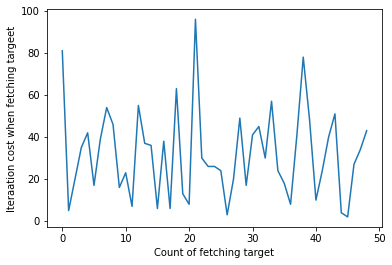

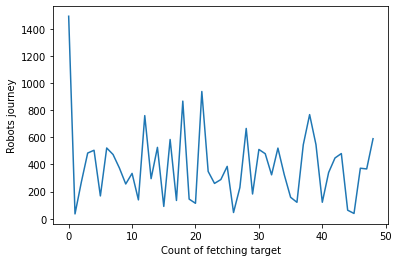

In [163]:
print(iteration_list)
plt.plot(iteration_list)
print(len(iteration_list))

print('Meaen iteration is ', np.mean(iteration_list))
print('Standard error is',np.std(iteration_list))
print('Variance error is',np.var(iteration_list))
print("Max value is",max(iteration_list),'Min is ',min(iteration_list))
print("Average cost is",total_journey/sum(iteration_list))
plt.xlabel('Count of fetching target')
plt.ylabel('Iteraation cost when fetching targeet')
plt.show()
plt.figure()
plt.plot(journey_list)
plt.xlabel('Count of fetching target')
plt.ylabel('Robots journey')
plt.show()